## Libraries

In [600]:
import os
import joblib

import shap
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

## Data Exploration and Preprocessing

### Loading & Inspection

Here's the summary statistics of feature columns as well as the target:

In [601]:
df=pd.read_csv(os.path.join("data", "MLE-Assignment.csv"));df.describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


Inspecting missing values in all columns:

In [602]:
int(df.isna().sum().sum())

0

In [ ]:
df.iloc[0].to_dict()

{'hsi_id': 'imagoai_corn_0',
 '0': 0.4161811824561809,
 '1': 0.3968436509479422,
 '2': 0.4089848698524103,
 '3': 0.3728651684270957,
 '4': 0.3852932484291667,
 '5': 0.3653898815539286,
 '6': 0.3552255272127901,
 '7': 0.3433501852815969,
 '8': 0.3448365257564199,
 '9': 0.3615670247888234,
 '10': 0.3573841082191937,
 '11': 0.3703400666292867,
 '12': 0.3542102397598498,
 '13': 0.3566946810009623,
 '14': 0.3452154357000861,
 '15': 0.3472142338559134,
 '16': 0.355947060823669,
 '17': 0.3584289448196784,
 '18': 0.3570549194251712,
 '19': 0.3469776655573572,
 '20': 0.3481271313926147,
 '21': 0.3258488797190481,
 '22': 0.3295315506720592,
 '23': 0.3370357804023883,
 '24': 0.316224229970188,
 '25': 0.3513012525089141,
 '26': 0.3373394823279348,
 '27': 0.3235300395192082,
 '28': 0.3133421598920886,
 '29': 0.3348166738757407,
 '30': 0.3088311862251046,
 '31': 0.3042625838431116,
 '32': 0.3219632758768377,
 '33': 0.3113457757615717,
 '34': 0.3132647873469752,
 '35': 0.3166648527295023,
 '36': 0.32

Visualizations of distribution of target:

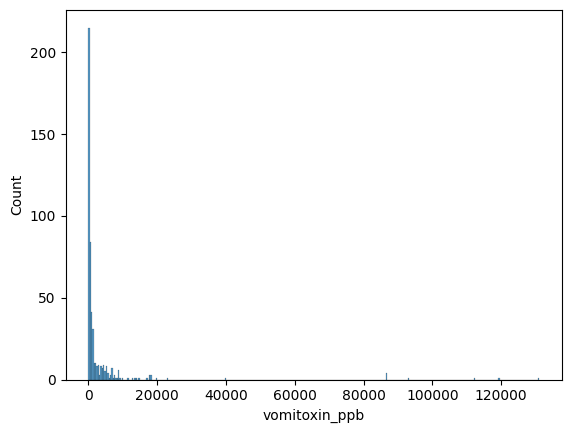

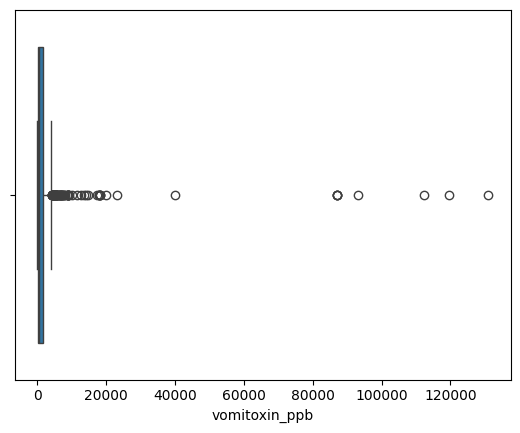

In [603]:
sns.histplot(data=df, x="vomitoxin_ppb")
plt.show()

sns.boxplot(data=df, x="vomitoxin_ppb")
plt.show()

### Preprocessing

In [604]:
# removing outliers in features
iso_forest = IsolationForest(contamination=0.20) 
outlier_labels = iso_forest.fit_predict(df.drop(["hsi_id", "vomitoxin_ppb"], axis=1))
outliers_feature = outlier_labels == -1
df = df[~outliers_feature]

# removing outliers in target
z_scores = np.abs(zscore(df["vomitoxin_ppb"]))
outliers_target = z_scores > 1.5
df = df[~outliers_target]

df = df[df["vomitoxin_ppb"]>0]
df = df[df["vomitoxin_ppb"]<1500]
df["vomitoxin_ppb"] = np.log10(df["vomitoxin_ppb"])

In [606]:
df["vomitoxin_ppb"].describe()

count    227.000000
mean       2.554420
std        0.400116
min        1.000000
25%        2.301030
50%        2.602060
75%        2.863282
max        3.146128
Name: vomitoxin_ppb, dtype: float64

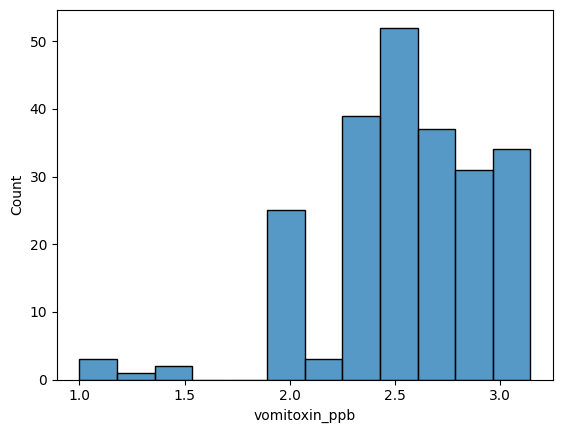

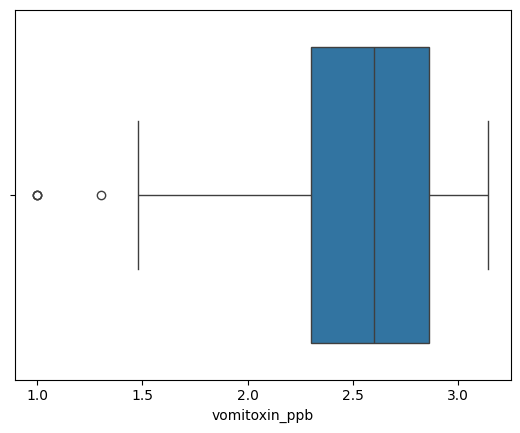

In [607]:
sns.histplot(data=df, x="vomitoxin_ppb")
plt.show()

sns.boxplot(data=df, x="vomitoxin_ppb")
plt.show()

In [608]:
target_col = df["vomitoxin_ppb"]
mean=target_col.mean()
std=target_col.std()
min_ = target_col.min()
max_ = target_col.max()

print("Mean:", mean)
print("Deviation:", std)
print("Min:", min_)
print("Max:", max_)

#df["vomitoxin_ppb"]=(df["vomitoxin_ppb"]-mean)/std

Mean: 2.5544203335472613
Deviation: 0.400115815366374
Min: 1.0
Max: 3.146128035678238


### Advanced Data Quality Checks

## Model Training

### Model Selection

In [627]:
class ToxinMLPRegressor(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.input_layer = nn.Linear(num_features, 16)
        self.hidden_layer1 = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer1(x))
        x = self.output_layer(x)
        return x

### Data Splitting

In [628]:
class ToxinDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float64)
        self.targets = torch.tensor(y, dtype=torch.float64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getdim__(self):
        return self.features.shape

### Training with K-Fold Validation

In [632]:
k=3
kf = KFold(n_splits=k, shuffle=True, random_state=1)

best_mse = float('inf')
best_model_state_dict = None
mse_scores = []

X = df.drop(["hsi_id", "vomitoxin_ppb"], axis=1).values
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = df["vomitoxin_ppb"].values / 3.5
dataset = ToxinDataset(X, y)
joblib.dump(scaler, "ToxinScaler.pkl")

lr = 0.001
num_epochs = 3000

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{k}")
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=64)
    val_loader = DataLoader(val_subset, batch_size=64)
    
    model = ToxinMLPRegressor(num_features=dataset.__getdim__()[1]).double()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(features.double())
            outputs = outputs.squeeze()
            loss = criterion(outputs, targets.double())
            loss.backward()
            optimizer.step()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features.double())
            val_loss += criterion(outputs, targets.double()).item()
    
    val_loss /= len(val_loader)
    mse_scores.append(val_loss)
    print(f"Validation MSE: {val_loss:.4f}")

    if val_loss < best_mse:
        best_train_loader = train_loader
        best_val_loader = val_loader
        best_model = model
        best_model_state_dict = model.state_dict()  
        best_mse = val_loss

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "ToxinModel.pth")
    print("Best model saved to 'ToxinModel.pth'")
    
print(f"Average MSE across {k} folds: {np.mean(mse_scores):.4f}")

Fold 1/3


/home/muthu/Desktop/Assignment/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/muthu/Desktop/Assignment/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation MSE: 0.0202
Fold 2/3
Validation MSE: 0.0243
Fold 3/3
Validation MSE: 0.0572
Best model saved to 'ToxinModel.pth'
Average MSE across 3 folds: 0.0339


/home/muthu/Desktop/Assignment/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Model Evaluation

### Metrics

In [635]:

y_true = y * 3.5
y_true = 10 ** y_true
y_pred = best_model(torch.tensor(X, dtype=torch.float64)).squeeze().detach().numpy()
y_pred = y_pred * 3.5 
y_pred = 10 ** y_pred 

mae = round(mean_absolute_error(y_true, y_pred), 4)
rmse = round(root_mean_squared_error(y_true, y_pred), 4)
r2 = round(r2_score(y_true, y_pred), 4)

print("Mean Absolute Error:", mae)
print("Root Mean Absolute Error:", rmse)
print("R2 Score:", r2)

Mean Absolute Error: 107.1915
Root Mean Absolute Error: 257.1719
R2 Score: 0.5116


### Visual Evaluation

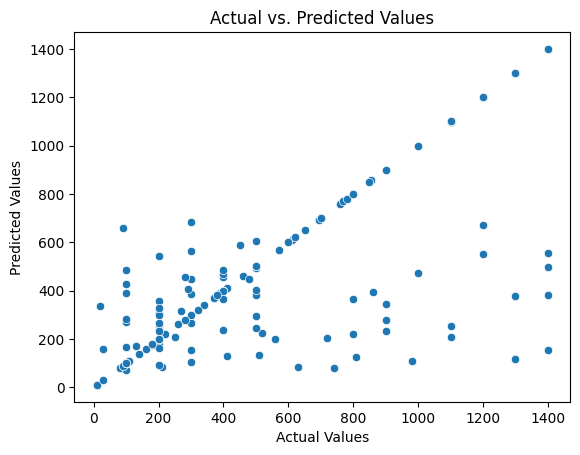

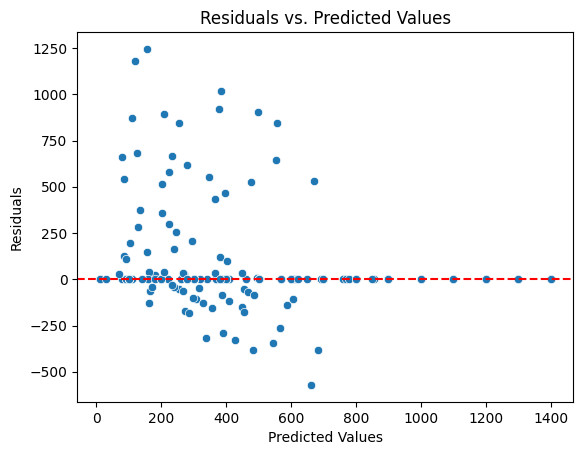

In [636]:

residuals = y_true - y_pred
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

In [585]:
import torch
import shap
import numpy as np
import pandas as pd

X = df.drop(["hsi_id", "vomitoxin_ppb"], axis=1).values
X_tensor = torch.tensor(X, dtype=torch.float64)

model = model.double()
model.eval()

feature_names = df.drop(["hsi_id", "vomitoxin_ppb"], axis=1).columns.str

background = X_tensor[:100]
print("Shape of background:", background.shape)

explainer = shap.DeepExplainer(model, data=background)

shap_values = explainer.shap_values(X_tensor)
print("Shape of SHAP values:", np.array(shap_values).shape)

expected_value = explainer.expected_value
model_output = model(X_tensor).detach().numpy()
shap_sum = np.sum(shap_values, axis=1) + expected_value
print("Shape of SHAP sum:", shap_sum.shape)

if not np.allclose(model_output, shap_sum, atol=1e-6):
    print("Warning: SHAP values do not sum up to the model's output.")
else:
    print("SHAP values match the model's output.")

print("Conclusion: SHAP values have been computed successfully and match the model's output.")

Shape of background: torch.Size([100, 448])
Shape of SHAP values: (256, 448, 1)
Shape of SHAP sum: (256, 1)
Conclusion: SHAP values have been computed successfully and match the model's output.


Number of feature names: 448
Feature names: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '438', '439', '440', '441', '442', '443', '444', '445', '446', '447'],
      dtype='object', length=448)
Shape of background: torch.Size([100, 448])
Shape of SHAP values: (210, 448, 1)
Shape of SHAP importance after flattening: (448,)
Top 10 indices: [198 386 221 189 259 374 331 419 254 298]
Shape of top 10 SHAP values: (210, 10, 1)
Top 10 feature names: ['198', '386', '221', '189', '259', '374', '331', '419', '254', '298']


<Figure size 640x480 with 0 Axes>

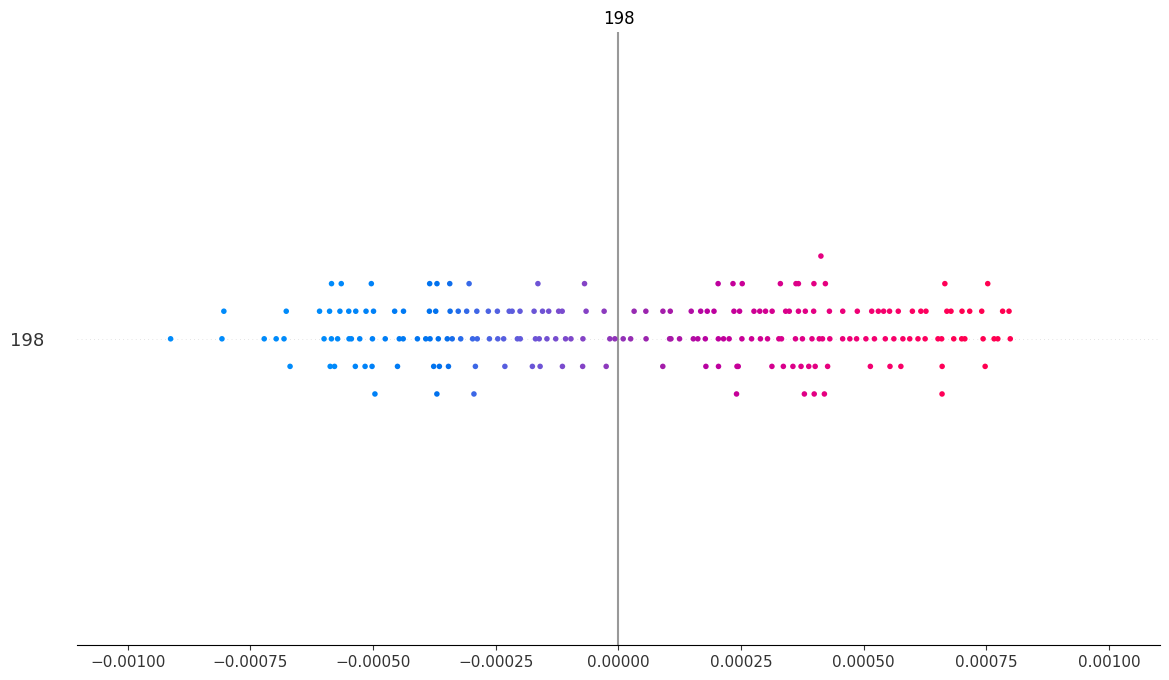

In [546]:

X = df.drop(["hsi_id", "vomitoxin_ppb"], axis=1).values  # Shape: (num_samples, num_features)
X_tensor = torch.tensor(X, dtype=torch.float64)  # Convert to PyTorch tensor

# Step 2: Extract feature names
feature_names = df.drop(["hsi_id", "vomitoxin_ppb"], axis=1).columns

#.tolist()
print("Number of feature names:", len(feature_names))
print("Feature names:", feature_names)

# Step 3: Use a background dataset
background = X_tensor[:100]  # Use a subset of 100 samples as the background
print("Shape of background:", background.shape)

# Step 4: Create the SHAP explainer
explainer = shap.DeepExplainer(model, data=background)

# Step 5: Compute SHAP values
shap_values = explainer.shap_values(X_tensor)  # Shape: (num_samples, num_features)
print("Shape of SHAP values:", np.array(shap_values).shape)

# Step 6: Calculate feature importance
shap_importance = np.mean(np.abs(shap_values), axis=0)  # Shape: (num_features,)
shap_importance = shap_importance.flatten()  # Ensure it's a 1D array
print("Shape of SHAP importance after flattening:", shap_importance.shape)

# Step 7: Sort features by importance and select top 10
top_10_indices = np.argsort(shap_importance)[-10:]  # Indices of top 10 features
top_10_indices = top_10_indices.flatten()  # Ensure it's a 1D array
print("Top 10 indices:", top_10_indices)

# Step 8: Select top 10 features
top_10_shap_values = shap_values[:, top_10_indices]  # Shape: (num_samples, 10)
top_10_feature_names = [feature_names[i] for i in top_10_indices]  # Names of top 10 features
print("Shape of top 10 SHAP values:", top_10_shap_values.shape)
print("Top 10 feature names:", top_10_feature_names)

# Step 9: Ensure data for plotting is correct
if len(top_10_shap_values.shape) == 1:
    top_10_shap_values = top_10_shap_values.reshape(-1, 1)  # Reshape to (num_samples, 1)

if len(X[:, top_10_indices].shape) == 1:
    X_top_10 = X[:, top_10_indices].reshape(-1, 1)  # Reshape to (num_samples, 1)
else:
    X_top_10 = X[:, top_10_indices]

# Step 10: Plot the SHAP summary plot for the top 10 features
shap.summary_plot(top_10_shap_values, X_top_10, feature_names=top_10_feature_names)
